# Import Packages

In [95]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, InputLayer, Input, BatchNormalization, Dropout
from tensorflow.keras.losses import mae, mse, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, f1_score, accuracy_score, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error, explained_variance_score, balanced_accuracy_score, precision_score, recall_score, matthews_corrcoef
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Import Data From Kaggle

In [2]:
!chmod 600 ~/ /content/drive/MyDrive/Hackathons/kaggle

In [3]:
!kaggle datasets download -d feeldidaxie/king-county-house-sales-usa

Dataset URL: https://www.kaggle.com/datasets/feeldidaxie/king-county-house-sales-usa
License(s): CC0-1.0
king-county-house-sales-usa.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/king-county-house-sales-usa.zip

Archive:  /content/king-county-house-sales-usa.zip
replace house_sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: house_sales.csv         


In [7]:
df = pd.read_csv("/content/house_sales.csv")

In [8]:
df.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
0,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
1,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
2,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
3,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
4,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


# Model That Will Experiments On This Dataset

1. Linear Regression
2. Decision Trees
3. Random Forest
4. Gradient Boosting
5. K-Nearest Neighbors
6. Support Vector Machines
7. Feed Forward Neural Network
8. Deep Neural Network

# Make Evaluate Prediction Function

In [9]:
def evaluate_model(y_true, y_pred, task_type="regression"):
    metrics = {}

    if task_type == "regression":
        metrics["MAE"] = mean_absolute_error(y_true, y_pred)
        metrics["MSE"] = mean_squared_error(y_true, y_pred)
        metrics["RMSE"] = np.sqrt(metrics["MSE"])
        metrics["MSLE"] = mean_squared_log_error(y_true, np.maximum(y_pred, 0))
        metrics["MAPE"] = mean_absolute_percentage_error(y_true, y_pred)
        metrics["MedAE"] = median_absolute_error(y_true, y_pred)
        metrics["R2"] = r2_score(y_true, y_pred)
        metrics["Explained Variance"] = explained_variance_score(y_true, y_pred)

    elif task_type == "classification":
        metrics["Accuracy"] = accuracy_score(y_true, y_pred)
        metrics["Balanced Accuracy"] = balanced_accuracy_score(y_true, y_pred)
        metrics["F1 Score"] = f1_score(y_true, y_pred, average="weighted")
        metrics["Precision"] = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        metrics["Recall"] = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        metrics["MCC"] = matthews_corrcoef(y_true, y_pred)

    return metrics

# Make Model Performance Plot Function

In [10]:
def plot_model_performance(y_true, y_pred, title):
    r2 = r2_score(y_true, y_pred)

    residuals = y_true - y_pred

    plt.scatter(y_true, y_pred, c=residuals, cmap='coolwarm', alpha=0.5, edgecolors='k')

    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linewidth=2, linestyle='--', label="Perfect Prediction Line")

    sns.regplot(x=y_true, y=y_pred, scatter=False, color='blue', line_kws={'linewidth': 2, 'color': 'blue', 'linestyle': '--'}, label="Best Fit Line")

    plt.title(title, fontsize=16)
    plt.xlabel('True Values', fontsize=14)
    plt.ylabel('Predicted Values', fontsize=14)

    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', color='black')

    plt.colorbar(label='Residuals', shrink=0.7)

    plt.legend(loc='best', fontsize=12)

    plt.tight_layout()
    plt.show()

# Preprocessing Data For Model

## Start Processing

In [11]:
df.isnull().sum()

,0
DocumentDate,0
SalePrice,0
PropertyID,0
PropertyType,0
ym,0
zhvi_px,0
zhvi_idx,0
AdjSalePrice,0
NbrLivingUnits,0
SqFtLot,0


In [12]:
df["DocumentDate"] = pd.to_datetime(df["DocumentDate"])
df['ym'] = pd.to_datetime(df["ym"])

In [13]:
df["Year"] = df["DocumentDate"].dt.year
df["Month"] = df["DocumentDate"].dt.month
df["Day"] = df["DocumentDate"].dt.day

In [14]:
df["PropertyType"] = df["PropertyType"].astype("category")
df["NewConstruction"] = df["NewConstruction"].astype("bool")

In [15]:
df = pd.get_dummies(df, columns=["PropertyType"], drop_first=True)

## Feature Engineering

In [16]:
df["PricePerSqFt"] = df["AdjSalePrice"] / df["SqFtLot"]

In [17]:
df["PropertyAge"] = df["Year"] - df["YrBuilt"]

In [18]:
df["Renovated"] = (df["YrRenovated"] > 0).astype("int")

In [19]:
Q1 = df['AdjSalePrice'].quantile(0.25)
Q3 = df['AdjSalePrice'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['AdjSalePrice'] >= (Q1 - 1.5 * IQR)) & (df['AdjSalePrice'] <= (Q3 + 1.5 * IQR))]

## Remove Unsual Columns

In [20]:
df.drop(['DocumentDate', 'ym', 'YrBuilt', 'YrRenovated'], axis=1, inplace=True)

In [21]:
df.head()

,SalePrice,PropertyID,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,...,ZipCode,NewConstruction,Year,Month,Day,PropertyType_Single Family,PropertyType_Townhouse,PricePerSqFt,PropertyAge,Renovated
0,280000,1000102,405100,0.930836,300805.0,2,9373,2400,0,3.00,...,98002,False,2014,9,16,False,False,32.092713,23,0
1,1000000,1200013,404400,0.929228,1076162.0,1,20156,3764,1452,3.75,...,98166,True,2006,6,16,True,False,53.391645,1,0
2,745000,1200019,425600,0.977941,761805.0,1,26036,2060,900,1.75,...,98166,False,2007,1,29,True,False,29.259679,60,0
3,425000,2800016,418400,0.961397,442065.0,1,8618,3200,1640,3.75,...,98168,False,2008,2,25,True,False,51.295544,42,0
4,240000,2800024,351600,0.807904,297065.0,1,8620,1720,0,1.75,...,98168,False,2013,3,29,True,False,34.462297,65,0


## More Preprocessing

In [22]:
X = df.drop("SalePrice", axis = 1)
y = df["SalePrice"]

In [23]:
X.head()

,PropertyID,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,...,ZipCode,NewConstruction,Year,Month,Day,PropertyType_Single Family,PropertyType_Townhouse,PricePerSqFt,PropertyAge,Renovated
0,1000102,405100,0.930836,300805.0,2,9373,2400,0,3.00,6,...,98002,False,2014,9,16,False,False,32.092713,23,0
1,1200013,404400,0.929228,1076162.0,1,20156,3764,1452,3.75,4,...,98166,True,2006,6,16,True,False,53.391645,1,0
2,1200019,425600,0.977941,761805.0,1,26036,2060,900,1.75,4,...,98166,False,2007,1,29,True,False,29.259679,60,0
3,2800016,418400,0.961397,442065.0,1,8618,3200,1640,3.75,5,...,98168,False,2008,2,25,True,False,51.295544,42,0
4,2800024,351600,0.807904,297065.0,1,8620,1720,0,1.75,4,...,98168,False,2013,3,29,True,False,34.462297,65,0


In [24]:
y[0]

280000

# Split Data Frame Into Train And Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [26]:
len(X_train), len(X_test), len(y_train), len(y_test)

(17086, 4272, 17086, 4272)

In [27]:
len(X)

21358

# Model 1: Linear Regression

In [28]:
model_1 = LinearRegression(positive=True)

In [29]:
model_1.fit(X_train, y_train)

LinearRegression(positive=True)

In [30]:
model_1_preds = model_1.predict(X_test)

In [31]:
model_1_preds[:10]

array([281525.45941446, 125213.69019623, 356282.90625635, 214075.45829101,
       183862.54533455, 312777.66960285, 449510.20125288, 372399.78094806,
       665810.02127791, 666543.66977121])

In [32]:
y_test[:10]

,SalePrice
16108,282000
8013,164000
19342,355000
6331,245000
12556,215000
13664,307000
16652,449000
11399,375000
8928,670000
17681,684950


In [33]:
model_1_results = evaluate_model(
    y_test,
    model_1_preds,
    task_type= "regression"
)

In [34]:
model_1_results

{'MAE': 11273.205223906754,
 'MSE': 283461738.9972706,
 'RMSE': 16836.322015133548,
 'MSLE': 0.03384002612600139,
 'MAPE': 0.030370659820769936,
 'MedAE': 7250.581483910733,
 'R2': 0.9908560341328505,
 'Explained Variance': 0.9908560401948945}

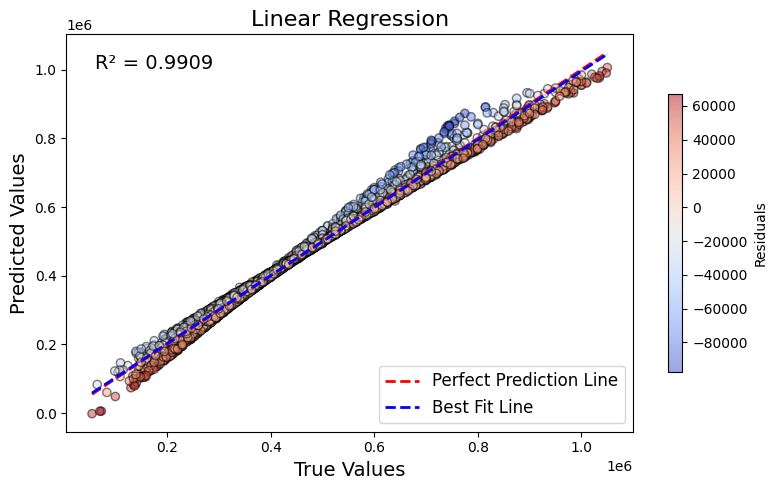

In [35]:
plt.figure(figsize=(8, 5))
plot_model_performance(y_test, model_1_preds, title = "Linear Regression")

# Model 2: Decision Tree

In [36]:
model_2 = DecisionTreeRegressor(
    max_depth= 100,
    min_impurity_decrease=0.5,
    max_features = 1000,
    )

In [37]:
model_2.fit(
    X_train,
    y_train
)

DecisionTreeRegressor(max_depth=100, max_features=1000,
                      min_impurity_decrease=0.5)

In [38]:
model_2_preds = model_2.predict(X_test)

In [39]:
model_2_preds[:10], len(model_2_preds)

(array([280016.66666667, 167000.        , 355000.        , 247500.        ,
        213500.        , 305000.        , 448000.        , 379000.        ,
        669800.        , 681950.        ]),
 4272)

In [40]:
y_test[:10], len(y_test)

(16108    282000
 8013     164000
 19342    355000
 6331     245000
 12556    215000
 13664    307000
 16652    449000
 11399    375000
 8928     670000
 17681    684950
 Name: SalePrice, dtype: int64,
 4272)

In [41]:
model_2_results = evaluate_model(y_test, model_2_preds, task_type="regression")

In [42]:
model_2_results

{'MAE': 2313.296018820869,
 'MSE': 16588720.848619765,
 'RMSE': 4072.925342873322,
 'MSLE': 8.838654738638946e-05,
 'MAPE': 0.005345003624684694,
 'MedAE': 1008.3333333333139,
 'R2': 0.999464877701816,
 'Explained Variance': 0.9994655408438267}

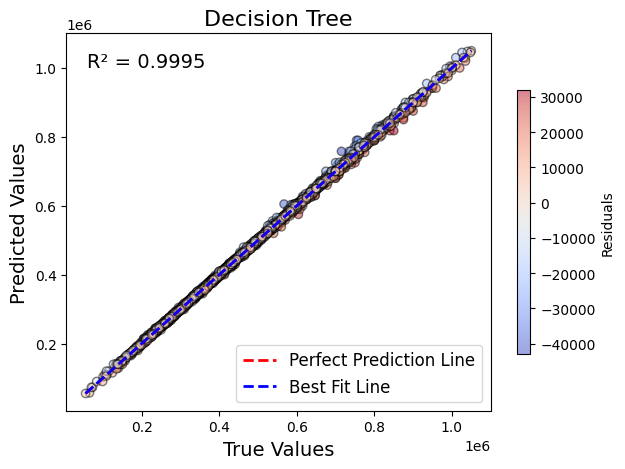

In [43]:
plot_model_performance(y_test, model_2_preds, title = "Decision Tree")

# Model 3: Random Forest

In [44]:
model_3 = RandomForestRegressor(
    n_estimators=200,
    warm_start=True,
)

In [45]:
model_3.fit(
    X_train,
    y_train
)

RandomForestRegressor(n_estimators=200, warm_start=True)

In [46]:
model_3_preds = model_3.predict(X_test)

In [47]:
model_3_preds[:10]

array([283456.31 , 165819.9  , 354790.44 , 245991.5  , 214985.875,
       306211.915, 447967.03 , 377856.5  , 670114.815, 683573.   ])

In [48]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [49]:
model_3_results = evaluate_model(y_test, model_3_preds)

In [50]:
model_3_results

{'MAE': 1022.3495166198505,
 'MSE': 3359725.1668309174,
 'RMSE': 1832.9553095563779,
 'MSLE': 1.8699566226350534e-05,
 'MAPE': 0.0023545974021844706,
 'MedAE': 561.109999999986,
 'R2': 0.9998916213089033,
 'Explained Variance': 0.9998916423673675}

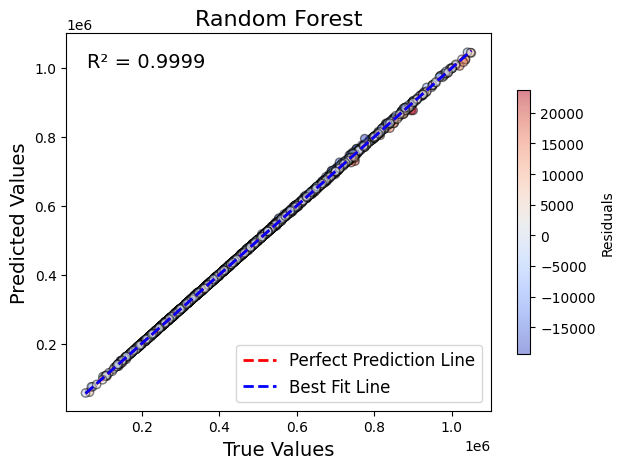

In [51]:
plot_model_performance(y_test, model_3_preds, title = "Random Forest")

# Model 4: Gradient Boosting

In [52]:
model_4 = GradientBoostingRegressor(
    n_estimators = 1000,
)

In [53]:
model_4.fit(
    X_train,
    y_train
)

GradientBoostingRegressor(n_estimators=1000)

In [54]:
model_4_preds = model_4.predict(X_test)

In [55]:
model_3_preds[:10]

array([283456.31 , 165819.9  , 354790.44 , 245991.5  , 214985.875,
       306211.915, 447967.03 , 377856.5  , 670114.815, 683573.   ])

In [56]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [57]:
model_4_results = evaluate_model(y_test, model_4_preds)

In [58]:
model_4_results

{'MAE': 1531.8540742691655,
 'MSE': 4620667.452469774,
 'RMSE': 2149.5737839092135,
 'MSLE': 2.9195840568738953e-05,
 'MAPE': 0.003662090810744803,
 'MedAE': 1113.3901250154595,
 'R2': 0.9998509455786933,
 'Explained Variance': 0.999850974323731}

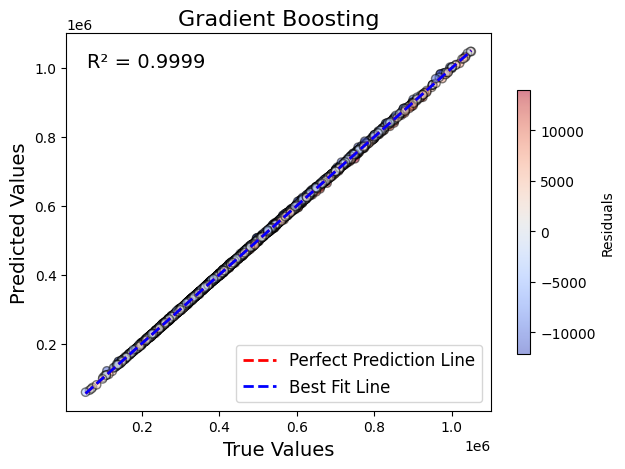

In [59]:
plot_model_performance(y_test, model_4_preds, title = "Gradient Boosting")

# Model 5: K-Nearest Neighbors

In [60]:
model_5 = KNeighborsRegressor()

In [61]:
model_5.fit(
    X_train,
    y_train
)

KNeighborsRegressor()

In [62]:
model_5_preds = model_5.predict(X_test)

In [63]:
model_5_preds[:10]

array([593600. , 478589.2, 306976.2, 288594. , 306359.8, 308580. ,
       466680. , 355195. , 483180. , 620611.6])

In [64]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [65]:
model_5_results = evaluate_model(y_test, model_5_preds)

In [66]:
model_5_results

{'MAE': 75205.57111423221,
 'MSE': 13083260522.01587,
 'RMSE': 114382.08129779712,
 'MSLE': 0.06689173033364745,
 'MAPE': 0.18725786459228735,
 'MedAE': 45415.0,
 'R2': 0.5779575470483889,
 'Explained Variance': 0.5789815779821244}

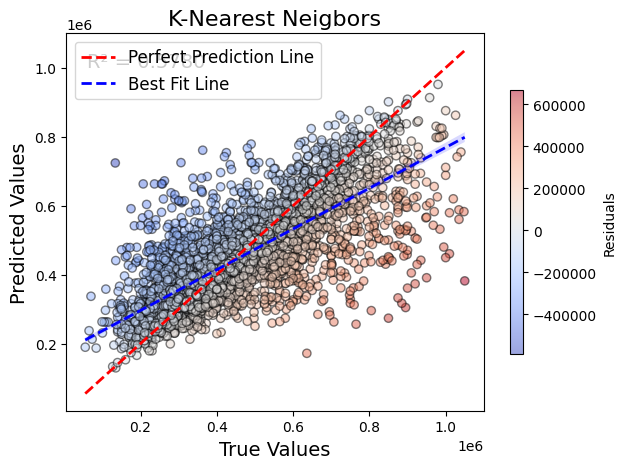

In [67]:
plot_model_performance(y_test, model_5_preds, title = "K-Nearest Neigbors")

# Model 6: Support Vector Machines

In [68]:
model_6 = SVR()

In [69]:
model_6.fit(
    X_train,
    y_train
)

SVR()

In [70]:
model_6_preds = model_6.predict(X_test)

In [71]:
model_6_preds[:10]

array([410229.65494304, 410003.50382577, 410288.83238207, 409997.90482858,
       410053.79488724, 410113.00472921, 410236.01696222, 410036.09181457,
       410011.26458588, 410264.3262869 ])

In [72]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [73]:
model_6_results = evaluate_model(y_test, model_6_preds)

In [74]:
model_6_results

{'MAE': 137147.14418193608,
 'MSE': 32488661635.179214,
 'RMSE': 180246.11406401862,
 'MSLE': 0.1564520002895644,
 'MAPE': 0.3315229151329919,
 'MedAE': 110000.73690958647,
 'R2': -0.048025790402379975,
 'Explained Variance': 7.308715991860559e-06}

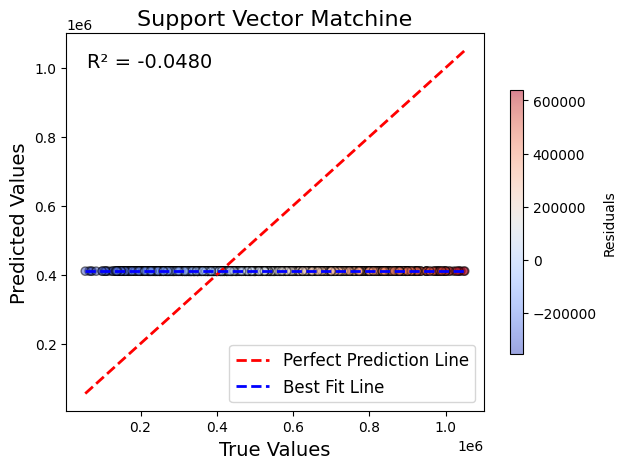

In [75]:
plot_model_performance(y_test, model_6_preds, title = "Support Vector Matchine")

# Model 7: Feed Forward Neural Network

In [76]:
model_7 = Sequential([
    InputLayer(input_shape =(X_train.shape[1],)),
    Dense(32, activation = "relu"),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [77]:
model_7.compile(
    loss = mse,
    optimizer = Adam(),
    metrics= ["mae"]
)

In [78]:
model_7.fit(
    X_train,
    y_train,
    epochs = 100
)

Epoch 1/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 111417387303043072.0000 - mae: 143229488.0000
Epoch 2/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 14621387776.0000 - mae: 94809.0234
Epoch 3/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14104360960.0000 - mae: 93320.3594
Epoch 4/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14087669760.0000 - mae: 93174.8906
Epoch 5/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13443024896.0000 - mae: 91000.0234
Epoch 6/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13393901568.0000 - mae: 90271.8281
Epoch 7/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12818784256.0000 - mae: 88349.8750
Epoch 8/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12053519360.0000 - mae: 85762.9453
Epoch 9/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11415488512.0000 - mae: 83270.9141
Epoch 10/100
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10609412096.0000 - mae: 80079.1797
Epoch 11/100
534/534 ━━━━━━━

In [79]:
model_7_preds = model_7.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


In [80]:
model_7_preds[:10]

array([[293343.9 ],
       [203703.92],
       [356095.9 ],
       [309799.9 ],
       [260063.92],
       [307679.9 ],
       [447903.9 ],
       [424111.9 ],
       [657119.94],
       [595903.94]], dtype=float32)

In [81]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [82]:
model_7_results = evaluate_model(y_test, tf.squeeze(model_7_preds).numpy())

In [83]:
model_7_results

{'MAE': 32370.951171875,
 'MSE': 1779655040.0,
 'RMSE': 42185.957853295215,
 'MSLE': 0.009413818828761578,
 'MAPE': 0.07725144922733307,
 'MedAE': 25780.078125,
 'R2': 0.9425915479660034,
 'Explained Variance': 0.9431956237704687}

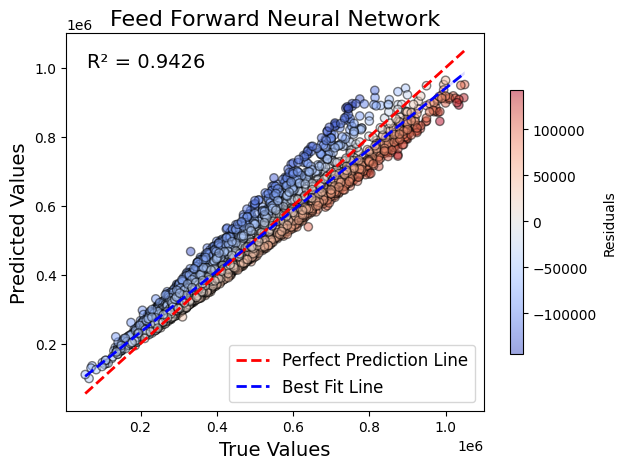

In [84]:
plot_model_performance(y_test, tf.squeeze(model_7_preds).numpy(), title = "Feed Forward Neural Network")

# Model 8: Deep Neural Network

In [135]:
model_8 = Sequential([
    InputLayer(shape = (X_train.shape[1],)),
    Dense(258, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation  = "relu"),
    Dense(1, activation = "linear")
])

In [136]:
model_8.compile(
    loss = mse,
    optimizer = Adam(learning_rate = 0.0001),
    metrics = ["mae"]
)

In [137]:
model_8.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 16,
)

Epoch 1/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2339934153211904.0000 - mae: 12567380.0000
Epoch 2/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 89175760896.0000 - mae: 241789.5312
Epoch 3/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 75268579328.0000 - mae: 215230.2500
Epoch 4/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 42157957120.0000 - mae: 159687.6250
Epoch 5/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 938838327296.0000 - mae: 410791.8438
Epoch 6/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6383900033024.0000 - mae: 762597.2500
Epoch 7/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27746650112.0000 - mae: 118008.0547
Epoch 8/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2748238266368.0000 - mae: 718124.5000
Epoch 9/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2231164469248.0000 - mae: 423722.0625
Epoch 10/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1958403112960.0000 - mae: 519284.9062


In [138]:
model_8_preds = model_8.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [139]:
model_8_preds[:10]

array([[233392.02],
       [174084.02],
       [279104.03],
       [250716.02],
       [212480.02],
       [239560.02],
       [369568.03],
       [330808.03],
       [501456.03],
       [403968.03]], dtype=float32)

In [140]:
y_test[:10].to_numpy()

array([282000, 164000, 355000, 245000, 215000, 307000, 449000, 375000,
       670000, 684950])

In [141]:
model_8_results = evaluate_model(y_test, model_8_preds)

In [142]:
model_8_results

{'MAE': 101968.1953125,
 'MSE': 15904442368.0,
 'RMSE': 126112.8160338988,
 'MSLE': 0.06913968175649643,
 'MAPE': 0.20748887956142426,
 'MedAE': 85387.96875,
 'R2': 0.4869512915611267,
 'Explained Variance': 0.7949891103386625}

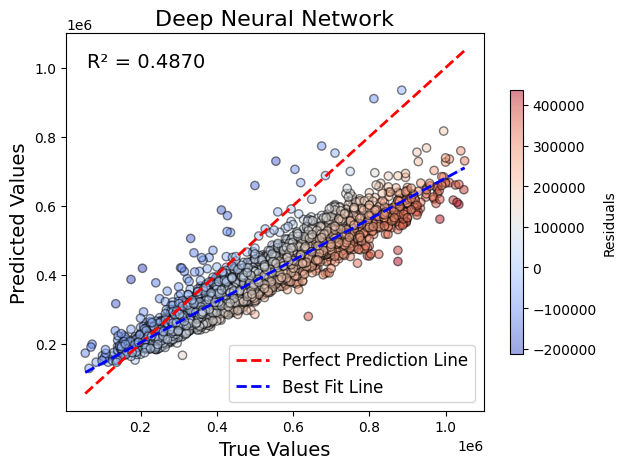

In [143]:
plot_model_performance(y_test, tf.squeeze(model_8_preds).numpy(), title = "Deep Neural Network")

# Compare All The Experiemnt Models

In [144]:
all_model_results = pd.DataFrame({
    "Linear Regression": [model_1_results["MAE"]],
    "Decision Tree": [model_2_results["MAE"]],
    "Random Forest": [model_3_results["MAE"]],
    "Gradient Boosting": [model_4_results["MAE"]],
    "K-Nearest Neighbors": [model_5_results["MAE"]],
    "Support Vector Matchine": [model_6_results["MAE"]],
    "Forward Neural Network": [model_7_results["MAE"]],
    "Deep Neural Network": [model_8_results["MAE"]],
}).transpose()

In [145]:
all_model_results

,0
Linear Regression,11273.205224
Decision Tree,2313.296019
Random Forest,1022.349517
Gradient Boosting,1531.854074
K-Nearest Neighbors,75205.571114
Support Vector Matchine,137147.144182
Forward Neural Network,32370.951172
Deep Neural Network,101968.195312


<ipython-input-146-e81772c52971>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_model_results.index, y=all_model_results[0], palette='Blues_d')


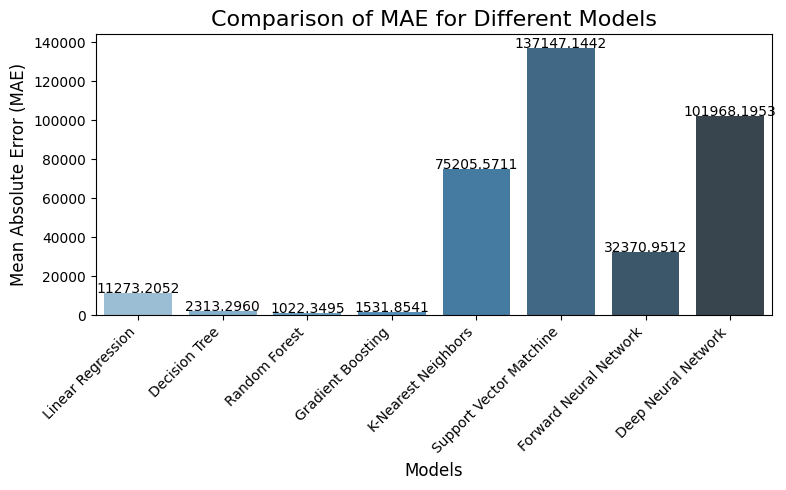

In [146]:
plt.figure(figsize=(8, 5))
sns.barplot(x=all_model_results.index, y=all_model_results[0], palette='Blues_d')

plt.title('Comparison of MAE for Different Models', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

for i, value in enumerate(all_model_results[0]):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()